<a href="https://colab.research.google.com/github/camulro/Aprendizaje-II/blob/sesi%C3%B3n4/cdcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Generativas Adversariales Condicionales (C-GANs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Creación de imágenes nuevas:**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Modelos Deep Learning**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

In [ ]:
# Basado en:
#
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

**Para más información:**

**Libros:**

- Capítulo 20 ("Deep Generative Models") de "Deep Learning" (2016): https://amzn.to/2YuwVjL

- Capítulo 8 ("Generative Deep Learning") de "Deep Learning with Python" (2017): https://amzn.to/2U2bHuP

**Artículos:**

- Generative Adversarial Networks (2014): https://arxiv.org/abs/1406.2661

- Tutorial: Generative Adversarial Networks, NIPS (2016): https://arxiv.org/abs/1701.00160

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (2015): https://arxiv.org/abs/1511.06434

- Conditional Generative Adversarial Nets (2014): https://arxiv.org/abs/1411.1784

- Image-To-Image Translation With Conditional Adversarial Networks (2017): https://arxiv.org/abs/1611.07004

- Conditional Generative Adversarial Nets For Convolutional Face Generation (2015): https://www.foldl.me/uploads/2015/conditional-gans-face-generation/paper.pdf

In [ ]:
COLAB    = True
GRAPHVIZ = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
# example of training an conditional gan on the fashion dataset
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import Dropout, Embedding, Concatenate

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# load fashion images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [ ]:
# load image data
dataset = load_real_samples()
X, y = dataset

4423680/4422102 [==============================] - 2s 0us/step


In [ ]:
X.shape, y.shape

((60000, 28, 28, 1), (60000,))

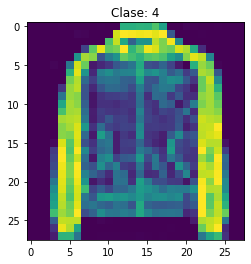

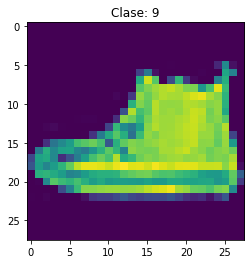

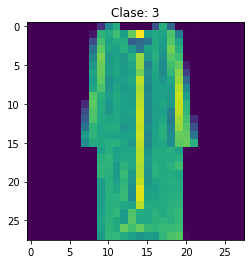

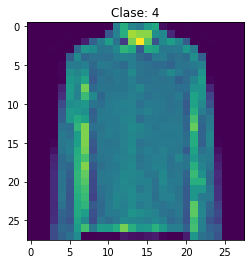

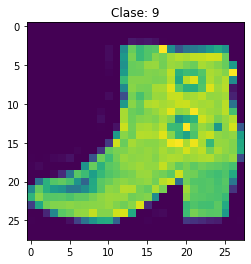

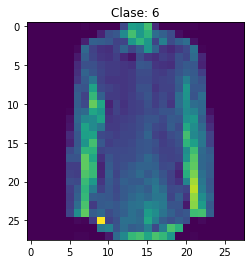

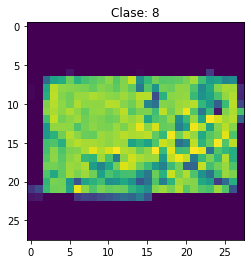

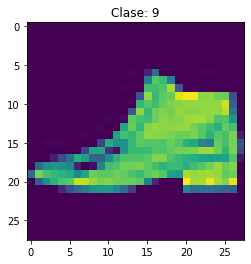

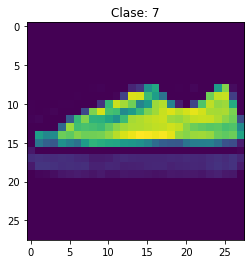

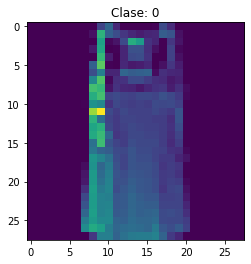

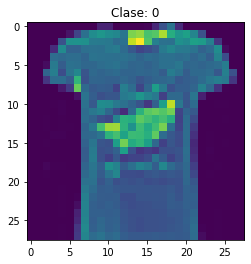

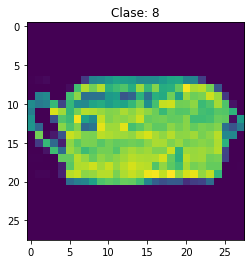

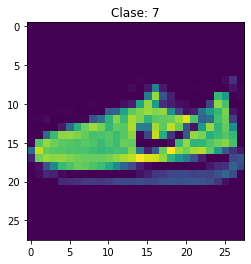

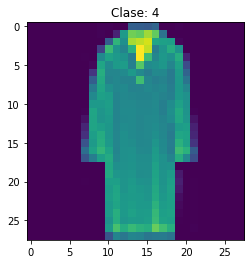

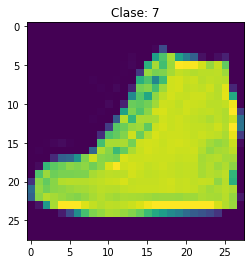

In [ ]:
n_ejemplos = 15

for i in randint(low=0, high=len(X), size=n_ejemplos):
    plt.imshow(X[i].reshape(28,28)) # cmap="gray"
    plt.title("Clase: {}".format(y[i]))
    plt.show()

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 32 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 32))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# size of the latent space
latent_dim = 100

# create the generator
generator = define_generator(latent_dim)
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1568)         158368      input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
___________

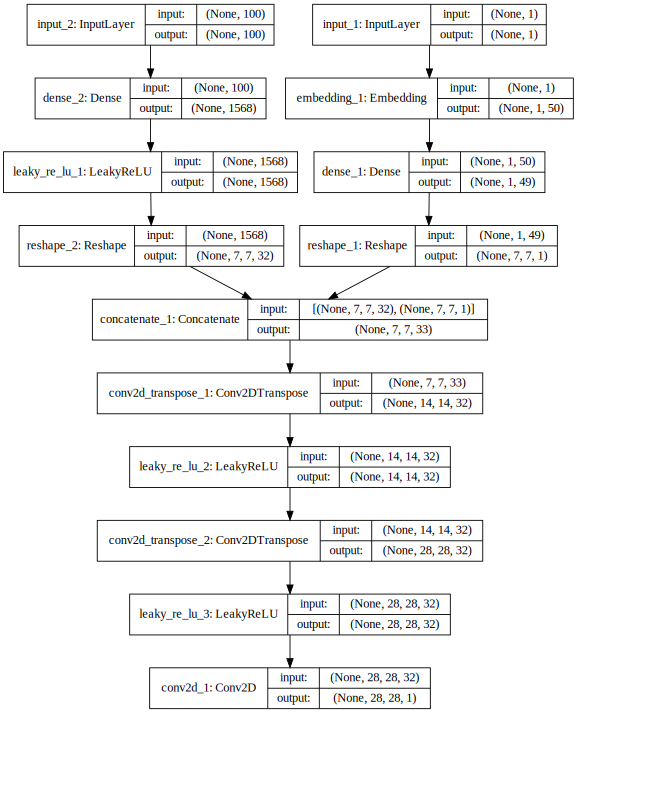

In [ ]:
if GRAPHVIZ:
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    if COLAB:
        display(SVG(model_to_dot(generator,show_shapes=True,dpi=64).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(generator,show_shapes=True).create(prog='dot', format='svg')))

El generador toma como entrada las variables latentes y la clase. 
Por la derecha asigna a cada categoria una imagen 7x7

In [ ]:
# create the discriminator
discriminator = define_discriminator()

discriminator.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 784)       39984       embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 1)    0                                           

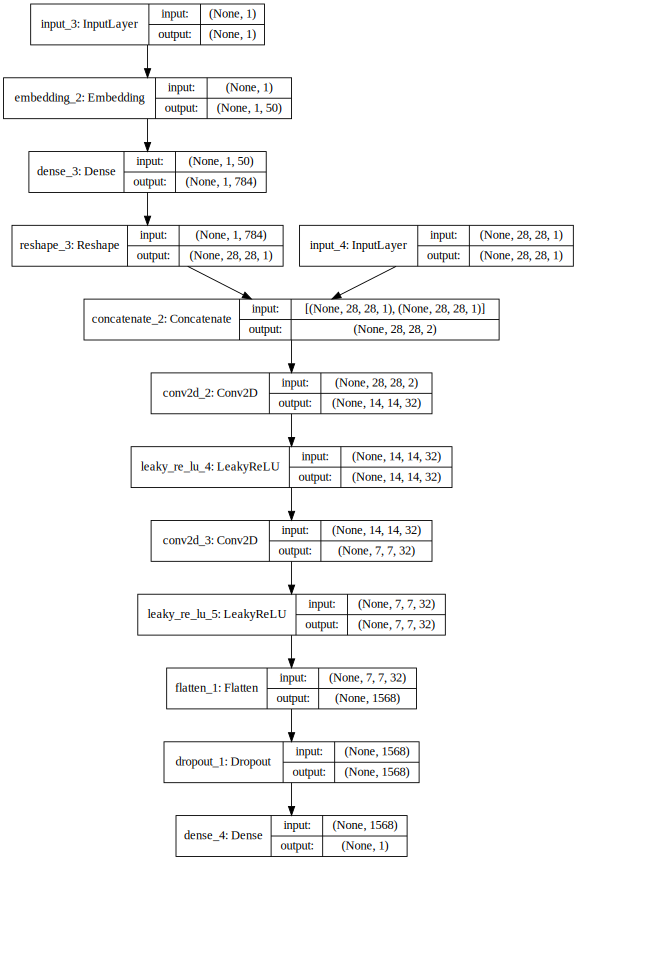

In [ ]:
if GRAPHVIZ:
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    if COLAB:
        display(SVG(model_to_dot(discriminator,show_shapes=True,dpi=64).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(discriminator,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
# create the gan
gan = define_gan(generator, discriminator)

gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1568)         158368      input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
____________________________________________________________________________________________

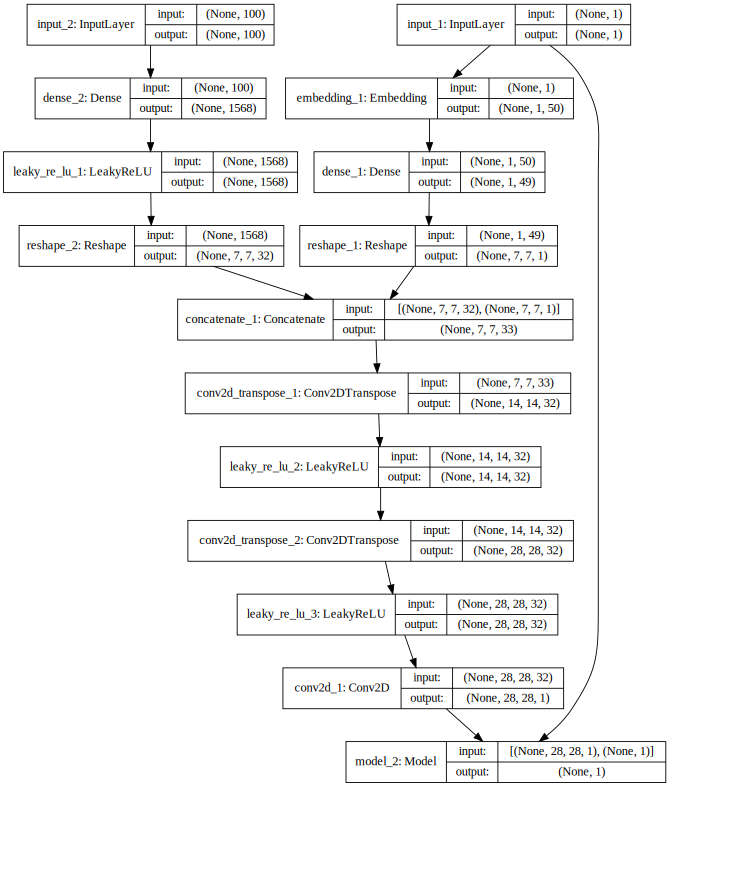

In [ ]:
if GRAPHVIZ:
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    if COLAB:
        display(SVG(model_to_dot(gan,show_shapes=True,dpi=64).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(gan,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def show_plot(examples, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

def plotGeneratedImages(generator, latent_dim, order_class=False):
		latent_points, labels = generate_latent_points(latent_dim, 100)
		if order_class:
				labels = asarray([x for _ in range(10) for x in range(10)])
		# generate images
		X  = generator.predict([latent_points, labels])
		# scale from [-1,1] to [0,1]
		X = (X + 1) / 2.0
		# plot the result
		show_plot(X)

EPOCH 1


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.679, d2=0.694 g=0.693
>1, 2/468, d1=0.645, d2=0.696 g=0.691
>1, 3/468, d1=0.616, d2=0.698 g=0.689
>1, 4/468, d1=0.586, d2=0.700 g=0.686
>1, 5/468, d1=0.557, d2=0.704 g=0.683
>1, 6/468, d1=0.542, d2=0.709 g=0.679
>1, 7/468, d1=0.524, d2=0.714 g=0.674
>1, 8/468, d1=0.497, d2=0.718 g=0.667
>1, 9/468, d1=0.476, d2=0.728 g=0.660


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 10/468, d1=0.466, d2=0.735 g=0.654
>1, 11/468, d1=0.446, d2=0.749 g=0.644
>1, 12/468, d1=0.417, d2=0.760 g=0.636
>1, 13/468, d1=0.398, d2=0.774 g=0.625
>1, 14/468, d1=0.378, d2=0.782 g=0.614
>1, 15/468, d1=0.377, d2=0.801 g=0.599
>1, 16/468, d1=0.353, d2=0.804 g=0.589
>1, 17/468, d1=0.359, d2=0.828 g=0.578
>1, 18/468, d1=0.336, d2=0.838 g=0.571
>1, 19/468, d1=0.335, d2=0.846 g=0.565
>1, 20/468, d1=0.329, d2=0.861 g=0.560
>1, 21/468, d1=0.337, d2=0.856 g=0.568
>1, 22/468, d1=0.311, d2=0.863 g=0.557
>1, 23/468, d1=0.312, d2=0.855 g=0.571
>1, 24/468, d1=0.316, d2=0.850 g=0.591
>1, 25/468, d1=0.320, d2=0.814 g=0.609
>1, 26/468, d1=0.321, d2=0.799 g=0.631
>1, 27/468, d1=0.316, d2=0.765 g=0.660
>1, 28/468, d1=0.322, d2=0.744 g=0.696
>1, 29/468, d1=0.324, d2=0.702 g=0.723
>1, 30/468, d1=0.336, d2=0.665 g=0.755
>1, 31/468, d1=0.313, d2=0.633 g=0.789
>1, 32/468, d1=0.348, d2=0.606 g=0.823
>1, 33/468, d1=0.329, d2=0.578 g=0.850
>1, 34/468, d1=0.341, d2=0.576 g=0.882
>1, 35/468, d1=0.350, d2=

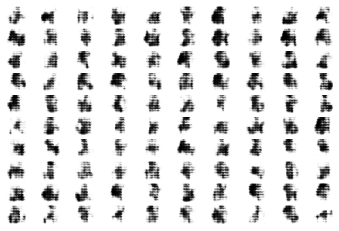

EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
>6, 1/468, d1=0.697, d2=0.672 g=0.712
>6, 2/468, d1=0.688, d2=0.694 g=0.721
>6, 3/468, d1=0.692, d2=0.683 g=0.731
>6, 4/468, d1=0.701, d2=0.696 g=0.724
>6, 5/468, d1=0.708, d2=0.689 g=0.715
>6, 6/468, d1=0.719, d2=0.683 g=0.721
>6, 7/468, d1=0.684, d2=0.682 g=0.714
>6, 8/468, d1=0.681, d2=0.686 g=0.723
>6, 9/468, d1=0.716, d2=0.692 g=0.720
>6, 10/468, d1=0.709, d2=0.675 g=0.717
>6, 11/468, d1=0.695, d2=0.680 g=0.722
>6, 12/468, d1=0.682, d2=0.699 g=0.719
>6, 13/468, d1=0.706, d2=0.683 g=0.728
>6, 14/468, d1=0.686, d2=0.678 g=0.712
>6, 15/468, d1=0.694, d2=0.684 g=0.727
>6, 16/468, d1=0.702, d2=0.673 g=0.711
>6, 17/468, d1=0.695, d2=0.672 g=0.727
>6, 18/468, d1=0.711, d2=0.676 g=0.716
>6, 19/468, d1=0.683, d2=0.680 g=0.712
>6, 20/468, d1=0.677, d2=0.687 g=0.714
>6, 21/468, d1=0.670, d2=0.668 g=0.714
>6, 22/468, d1=0.720, d2=0.675 g=0.713
>6, 23/468, d1=0.710, d2=0.677 g=0.727
>6, 24/468, d1=0.689, d2=0.676 g=0.713
>6, 25/468, d1=0.691, d2=0.684 g=

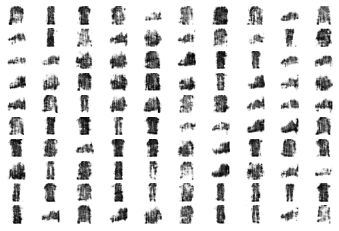

EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
>11, 1/468, d1=0.671, d2=0.680 g=0.721
>11, 2/468, d1=0.689, d2=0.675 g=0.725
>11, 3/468, d1=0.692, d2=0.684 g=0.729
>11, 4/468, d1=0.692, d2=0.676 g=0.718
>11, 5/468, d1=0.678, d2=0.653 g=0.719
>11, 6/468, d1=0.702, d2=0.685 g=0.740
>11, 7/468, d1=0.690, d2=0.660 g=0.731
>11, 8/468, d1=0.685, d2=0.671 g=0.729
>11, 9/468, d1=0.697, d2=0.675 g=0.721
>11, 10/468, d1=0.672, d2=0.673 g=0.733
>11, 11/468, d1=0.656, d2=0.674 g=0.729
>11, 12/468, d1=0.689, d2=0.668 g=0.729
>11, 13/468, d1=0.675, d2=0.662 g=0.744
>11, 14/468, d1=0.678, d2=0.663 g=0.739
>11, 15/468, d1=0.672, d2=0.660 g=0.731
>11, 16/468, d1=0.680, d2=0.680 g=0.735
>11, 17/468, d1=0.661, d2=0.663 g=0.725
>11, 18/468, d1=0.700, d2=0.667 g=0.716
>11, 19/468, d1=0.659, d2=0.691 g=0.719
>11, 20/468, d1=0.695, d2=0.678 g=0.735
>11, 21/468, d1=0.672, d2=0.667 g=0.730
>11, 22/468, d1=0.670, d2=0.671 g=0.738
>11, 23/468, d1=0.668, d2=0.674 g=0.738
>11, 24/468, d1=0.677, d2=0.665 g=0.726
>11, 25

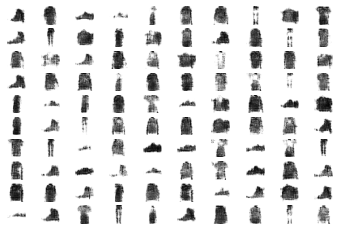

EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
>16, 1/468, d1=0.676, d2=0.674 g=0.731
>16, 2/468, d1=0.665, d2=0.680 g=0.742
>16, 3/468, d1=0.687, d2=0.668 g=0.733
>16, 4/468, d1=0.669, d2=0.687 g=0.731
>16, 5/468, d1=0.672, d2=0.669 g=0.748
>16, 6/468, d1=0.657, d2=0.674 g=0.741
>16, 7/468, d1=0.682, d2=0.669 g=0.719
>16, 8/468, d1=0.692, d2=0.677 g=0.755
>16, 9/468, d1=0.663, d2=0.669 g=0.735
>16, 10/468, d1=0.703, d2=0.678 g=0.750
>16, 11/468, d1=0.637, d2=0.672 g=0.734
>16, 12/468, d1=0.665, d2=0.650 g=0.728
>16, 13/468, d1=0.693, d2=0.672 g=0.718
>16, 14/468, d1=0.650, d2=0.697 g=0.737
>16, 15/468, d1=0.708, d2=0.678 g=0.741
>16, 16/468, d1=0.649, d2=0.673 g=0.737
>16, 17/468, d1=0.680, d2=0.714 g=0.739
>16, 18/468, d1=0.653, d2=0.662 g=0.716
>16, 19/468, d1=0.672, d2=0.662 g=0.727
>16, 20/468, d1=0.686, d2=0.655 g=0.732
>16, 21/468, d1=0.693, d2=0.701 g=0.717
>16, 22/468, d1=0.660, d2=0.679 g=0.731
>16, 23/468, d1=0.686, d2=0.645 g=0.733
>16, 24/468, d1=0.699, d2=0.676 g=0.731
>16,

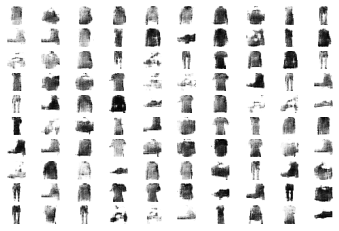

EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
>21, 1/468, d1=0.658, d2=0.669 g=0.757
>21, 2/468, d1=0.689, d2=0.668 g=0.747
>21, 3/468, d1=0.691, d2=0.668 g=0.759
>21, 4/468, d1=0.666, d2=0.653 g=0.740
>21, 5/468, d1=0.680, d2=0.666 g=0.745
>21, 6/468, d1=0.671, d2=0.642 g=0.748
>21, 7/468, d1=0.688, d2=0.672 g=0.723
>21, 8/468, d1=0.675, d2=0.668 g=0.727
>21, 9/468, d1=0.682, d2=0.655 g=0.754
>21, 10/468, d1=0.643, d2=0.694 g=0.749
>21, 11/468, d1=0.672, d2=0.663 g=0.715
>21, 12/468, d1=0.689, d2=0.664 g=0.749
>21, 13/468, d1=0.656, d2=0.668 g=0.739
>21, 14/468, d1=0.671, d2=0.646 g=0.744
>21, 15/468, d1=0.680, d2=0.667 g=0.747
>21, 16/468, d1=0.680, d2=0.657 g=0.757
>21, 17/468, d1=0.686, d2=0.697 g=0.741
>21, 18/468, d1=0.670, d2=0.680 g=0.750
>21, 19/468, d1=0.677, d2=0.654 g=0.734
>21, 20/468, d1=0.694, d2=0.702 g=0.728
>21, 21/468, d1=0.671, d2=0.657 g=0.759
>21, 22/468, d1=0.663, d2=0.668 g=0.771
>21, 23/468, d1=0.652, d2=0.654 g=0.737
>21, 24/468, d1=0.685, d2=0.666 g=0.764
>21,

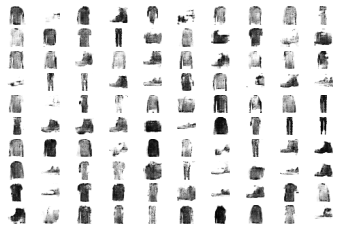

EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
>26, 1/468, d1=0.668, d2=0.688 g=0.734
>26, 2/468, d1=0.685, d2=0.677 g=0.726
>26, 3/468, d1=0.656, d2=0.680 g=0.724
>26, 4/468, d1=0.647, d2=0.639 g=0.730
>26, 5/468, d1=0.637, d2=0.662 g=0.726
>26, 6/468, d1=0.688, d2=0.684 g=0.728
>26, 7/468, d1=0.691, d2=0.681 g=0.741
>26, 8/468, d1=0.668, d2=0.667 g=0.742
>26, 9/468, d1=0.680, d2=0.664 g=0.745
>26, 10/468, d1=0.681, d2=0.686 g=0.730
>26, 11/468, d1=0.687, d2=0.651 g=0.736
>26, 12/468, d1=0.654, d2=0.651 g=0.771
>26, 13/468, d1=0.675, d2=0.641 g=0.743
>26, 14/468, d1=0.695, d2=0.695 g=0.743
>26, 15/468, d1=0.662, d2=0.662 g=0.719
>26, 16/468, d1=0.673, d2=0.658 g=0.734
>26, 17/468, d1=0.680, d2=0.695 g=0.740
>26, 18/468, d1=0.686, d2=0.697 g=0.744
>26, 19/468, d1=0.679, d2=0.680 g=0.728
>26, 20/468, d1=0.660, d2=0.692 g=0.733
>26, 21/468, d1=0.666, d2=0.671 g=0.733
>26, 22/468, d1=0.665, d2=0.681 g=0.744
>26, 23/468, d1=0.686, d2=0.665 g=0.747
>26, 24/468, d1=0.695, d2=0.654 g=0.740
>26,

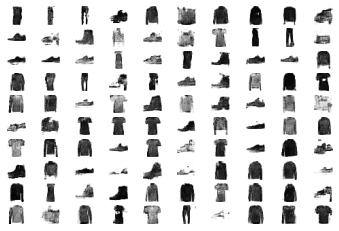

EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
>31, 1/468, d1=0.626, d2=0.650 g=0.776
>31, 2/468, d1=0.679, d2=0.618 g=0.781
>31, 3/468, d1=0.677, d2=0.631 g=0.782
>31, 4/468, d1=0.674, d2=0.696 g=0.776
>31, 5/468, d1=0.651, d2=0.668 g=0.750
>31, 6/468, d1=0.682, d2=0.677 g=0.732
>31, 7/468, d1=0.684, d2=0.655 g=0.766
>31, 8/468, d1=0.675, d2=0.656 g=0.749
>31, 9/468, d1=0.655, d2=0.669 g=0.774
>31, 10/468, d1=0.677, d2=0.679 g=0.763
>31, 11/468, d1=0.667, d2=0.649 g=0.780
>31, 12/468, d1=0.657, d2=0.671 g=0.780
>31, 13/468, d1=0.649, d2=0.655 g=0.751
>31, 14/468, d1=0.685, d2=0.647 g=0.744
>31, 15/468, d1=0.639, d2=0.698 g=0.742
>31, 16/468, d1=0.700, d2=0.721 g=0.744
>31, 17/468, d1=0.678, d2=0.678 g=0.764
>31, 18/468, d1=0.678, d2=0.660 g=0.763
>31, 19/468, d1=0.714, d2=0.648 g=0.758
>31, 20/468, d1=0.677, d2=0.669 g=0.764
>31, 21/468, d1=0.693, d2=0.620 g=0.744
>31, 22/468, d1=0.691, d2=0.669 g=0.772
>31, 23/468, d1=0.677, d2=0.669 g=0.773
>31, 24/468, d1=0.699, d2=0.706 g=0.751
>31,

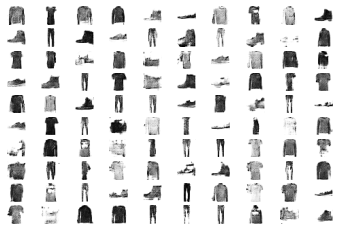

EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
>36, 1/468, d1=0.670, d2=0.666 g=0.767
>36, 2/468, d1=0.643, d2=0.704 g=0.787
>36, 3/468, d1=0.683, d2=0.653 g=0.825
>36, 4/468, d1=0.728, d2=0.632 g=0.753
>36, 5/468, d1=0.684, d2=0.674 g=0.769
>36, 6/468, d1=0.681, d2=0.635 g=0.743
>36, 7/468, d1=0.666, d2=0.701 g=0.743
>36, 8/468, d1=0.705, d2=0.674 g=0.758
>36, 9/468, d1=0.673, d2=0.652 g=0.746
>36, 10/468, d1=0.671, d2=0.665 g=0.757
>36, 11/468, d1=0.663, d2=0.665 g=0.770
>36, 12/468, d1=0.656, d2=0.665 g=0.764
>36, 13/468, d1=0.671, d2=0.654 g=0.753
>36, 14/468, d1=0.645, d2=0.677 g=0.754
>36, 15/468, d1=0.674, d2=0.702 g=0.746
>36, 16/468, d1=0.705, d2=0.702 g=0.748
>36, 17/468, d1=0.708, d2=0.666 g=0.769
>36, 18/468, d1=0.647, d2=0.624 g=0.796
>36, 19/468, d1=0.690, d2=0.657 g=0.760
>36, 20/468, d1=0.647, d2=0.625 g=0.747
>36, 21/468, d1=0.705, d2=0.688 g=0.764
>36, 22/468, d1=0.655, d2=0.648 g=0.749
>36, 23/468, d1=0.671, d2=0.692 g=0.757
>36, 24/468, d1=0.649, d2=0.656 g=0.759
>36,

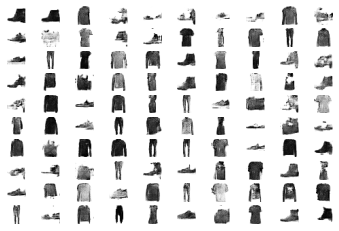

EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
>41, 1/468, d1=0.672, d2=0.683 g=0.782
>41, 2/468, d1=0.654, d2=0.657 g=0.744
>41, 3/468, d1=0.648, d2=0.669 g=0.745
>41, 4/468, d1=0.706, d2=0.651 g=0.738
>41, 5/468, d1=0.678, d2=0.671 g=0.755
>41, 6/468, d1=0.698, d2=0.675 g=0.781
>41, 7/468, d1=0.652, d2=0.677 g=0.761
>41, 8/468, d1=0.640, d2=0.673 g=0.763
>41, 9/468, d1=0.651, d2=0.651 g=0.780
>41, 10/468, d1=0.659, d2=0.717 g=0.756
>41, 11/468, d1=0.702, d2=0.665 g=0.765
>41, 12/468, d1=0.661, d2=0.671 g=0.771
>41, 13/468, d1=0.664, d2=0.669 g=0.752
>41, 14/468, d1=0.716, d2=0.658 g=0.742
>41, 15/468, d1=0.635, d2=0.662 g=0.761
>41, 16/468, d1=0.667, d2=0.698 g=0.760
>41, 17/468, d1=0.698, d2=0.665 g=0.733
>41, 18/468, d1=0.665, d2=0.646 g=0.752
>41, 19/468, d1=0.689, d2=0.674 g=0.765
>41, 20/468, d1=0.632, d2=0.730 g=0.754
>41, 21/468, d1=0.706, d2=0.693 g=0.754
>41, 22/468, d1=0.712, d2=0.651 g=0.772
>41, 23/468, d1=0.674, d2=0.647 g=0.742
>41, 24/468, d1=0.672, d2=0.676 g=0.749
>41,

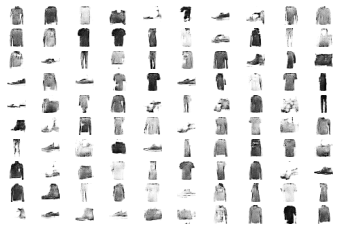

EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
>46, 1/468, d1=0.703, d2=0.696 g=0.758
>46, 2/468, d1=0.686, d2=0.650 g=0.765
>46, 3/468, d1=0.671, d2=0.679 g=0.771
>46, 4/468, d1=0.660, d2=0.654 g=0.774
>46, 5/468, d1=0.686, d2=0.675 g=0.744
>46, 6/468, d1=0.724, d2=0.654 g=0.785
>46, 7/468, d1=0.689, d2=0.648 g=0.783
>46, 8/468, d1=0.677, d2=0.672 g=0.769
>46, 9/468, d1=0.678, d2=0.645 g=0.745
>46, 10/468, d1=0.649, d2=0.683 g=0.773
>46, 11/468, d1=0.681, d2=0.663 g=0.782
>46, 12/468, d1=0.671, d2=0.628 g=0.770
>46, 13/468, d1=0.659, d2=0.670 g=0.768
>46, 14/468, d1=0.672, d2=0.682 g=0.762
>46, 15/468, d1=0.627, d2=0.674 g=0.763
>46, 16/468, d1=0.635, d2=0.662 g=0.773
>46, 17/468, d1=0.659, d2=0.645 g=0.742
>46, 18/468, d1=0.679, d2=0.707 g=0.759
>46, 19/468, d1=0.644, d2=0.654 g=0.749
>46, 20/468, d1=0.656, d2=0.668 g=0.769
>46, 21/468, d1=0.682, d2=0.662 g=0.759
>46, 22/468, d1=0.695, d2=0.679 g=0.785
>46, 23/468, d1=0.644, d2=0.648 g=0.762
>46, 24/468, d1=0.663, d2=0.693 g=0.754
>46,

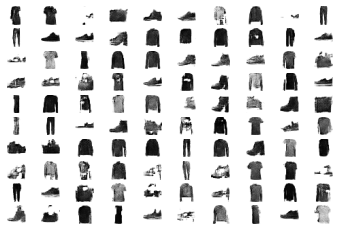

EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
>51, 1/468, d1=0.670, d2=0.640 g=0.763
>51, 2/468, d1=0.666, d2=0.689 g=0.783
>51, 3/468, d1=0.710, d2=0.680 g=0.766
>51, 4/468, d1=0.653, d2=0.660 g=0.753
>51, 5/468, d1=0.701, d2=0.663 g=0.780
>51, 6/468, d1=0.657, d2=0.650 g=0.732
>51, 7/468, d1=0.661, d2=0.670 g=0.774
>51, 8/468, d1=0.683, d2=0.657 g=0.767
>51, 9/468, d1=0.708, d2=0.686 g=0.770
>51, 10/468, d1=0.656, d2=0.668 g=0.761
>51, 11/468, d1=0.673, d2=0.698 g=0.756
>51, 12/468, d1=0.669, d2=0.638 g=0.798
>51, 13/468, d1=0.712, d2=0.691 g=0.721
>51, 14/468, d1=0.658, d2=0.667 g=0.752
>51, 15/468, d1=0.628, d2=0.672 g=0.769
>51, 16/468, d1=0.617, d2=0.626 g=0.770
>51, 17/468, d1=0.687, d2=0.653 g=0.772
>51, 18/468, d1=0.683, d2=0.670 g=0.757
>51, 19/468, d1=0.633, d2=0.648 g=0.763
>51, 20/468, d1=0.664, d2=0.699 g=0.741
>51, 21/468, d1=0.654, d2=0.739 g=0.741
>51, 22/468, d1=0.661, d2=0.646 g=0.775
>51, 23/468, d1=0.658, d2=0.635 g=0.793
>51, 24/468, d1=0.646, d2=0.653 g=0.817
>51,

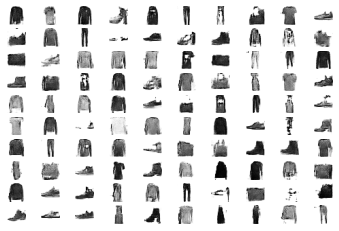

EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
>56, 1/468, d1=0.702, d2=0.702 g=0.800
>56, 2/468, d1=0.669, d2=0.657 g=0.815
>56, 3/468, d1=0.711, d2=0.627 g=0.798
>56, 4/468, d1=0.713, d2=0.657 g=0.792
>56, 5/468, d1=0.649, d2=0.636 g=0.786
>56, 6/468, d1=0.697, d2=0.645 g=0.789
>56, 7/468, d1=0.689, d2=0.663 g=0.753
>56, 8/468, d1=0.644, d2=0.694 g=0.779
>56, 9/468, d1=0.704, d2=0.660 g=0.744
>56, 10/468, d1=0.663, d2=0.628 g=0.772
>56, 11/468, d1=0.740, d2=0.649 g=0.801
>56, 12/468, d1=0.644, d2=0.689 g=0.797
>56, 13/468, d1=0.683, d2=0.630 g=0.761
>56, 14/468, d1=0.679, d2=0.667 g=0.744
>56, 15/468, d1=0.674, d2=0.652 g=0.758
>56, 16/468, d1=0.665, d2=0.656 g=0.771
>56, 17/468, d1=0.669, d2=0.677 g=0.777
>56, 18/468, d1=0.646, d2=0.640 g=0.800
>56, 19/468, d1=0.673, d2=0.707 g=0.771
>56, 20/468, d1=0.635, d2=0.653 g=0.751
>56, 21/468, d1=0.646, d2=0.665 g=0.757
>56, 22/468, d1=0.633, d2=0.628 g=0.787
>56, 23/468, d1=0.659, d2=0.637 g=0.777
>56, 24/468, d1=0.652, d2=0.653 g=0.751
>56,

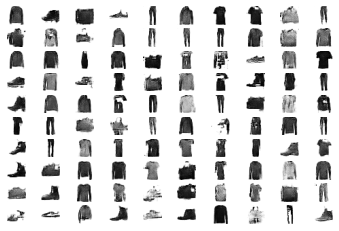

EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
>61, 1/468, d1=0.673, d2=0.662 g=0.786
>61, 2/468, d1=0.713, d2=0.681 g=0.767
>61, 3/468, d1=0.694, d2=0.676 g=0.765
>61, 4/468, d1=0.659, d2=0.678 g=0.743
>61, 5/468, d1=0.644, d2=0.680 g=0.769
>61, 6/468, d1=0.647, d2=0.651 g=0.771
>61, 7/468, d1=0.665, d2=0.618 g=0.775
>61, 8/468, d1=0.683, d2=0.638 g=0.757
>61, 9/468, d1=0.617, d2=0.667 g=0.767
>61, 10/468, d1=0.649, d2=0.689 g=0.776
>61, 11/468, d1=0.682, d2=0.644 g=0.823
>61, 12/468, d1=0.651, d2=0.638 g=0.770
>61, 13/468, d1=0.628, d2=0.673 g=0.779
>61, 14/468, d1=0.627, d2=0.643 g=0.789
>61, 15/468, d1=0.718, d2=0.636 g=0.770
>61, 16/468, d1=0.627, d2=0.651 g=0.802
>61, 17/468, d1=0.671, d2=0.659 g=0.771
>61, 18/468, d1=0.701, d2=0.692 g=0.780
>61, 19/468, d1=0.675, d2=0.621 g=0.760
>61, 20/468, d1=0.651, d2=0.667 g=0.761
>61, 21/468, d1=0.660, d2=0.677 g=0.772
>61, 22/468, d1=0.660, d2=0.660 g=0.802
>61, 23/468, d1=0.684, d2=0.693 g=0.780
>61, 24/468, d1=0.670, d2=0.663 g=0.761
>61,

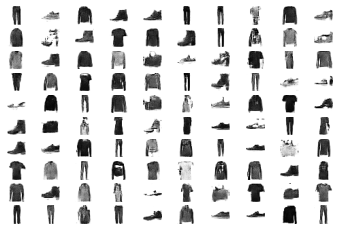

EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
>66, 1/468, d1=0.695, d2=0.651 g=0.767
>66, 2/468, d1=0.680, d2=0.664 g=0.770
>66, 3/468, d1=0.672, d2=0.662 g=0.740
>66, 4/468, d1=0.649, d2=0.647 g=0.763
>66, 5/468, d1=0.668, d2=0.691 g=0.748
>66, 6/468, d1=0.697, d2=0.672 g=0.768
>66, 7/468, d1=0.659, d2=0.654 g=0.817
>66, 8/468, d1=0.643, d2=0.651 g=0.791
>66, 9/468, d1=0.697, d2=0.622 g=0.801
>66, 10/468, d1=0.688, d2=0.690 g=0.772
>66, 11/468, d1=0.695, d2=0.679 g=0.761
>66, 12/468, d1=0.655, d2=0.657 g=0.763
>66, 13/468, d1=0.658, d2=0.660 g=0.759
>66, 14/468, d1=0.660, d2=0.685 g=0.776
>66, 15/468, d1=0.668, d2=0.647 g=0.752
>66, 16/468, d1=0.668, d2=0.673 g=0.779
>66, 17/468, d1=0.672, d2=0.623 g=0.794
>66, 18/468, d1=0.691, d2=0.704 g=0.802
>66, 19/468, d1=0.641, d2=0.676 g=0.774
>66, 20/468, d1=0.697, d2=0.620 g=0.788
>66, 21/468, d1=0.709, d2=0.671 g=0.787
>66, 22/468, d1=0.677, d2=0.669 g=0.802
>66, 23/468, d1=0.680, d2=0.666 g=0.801
>66, 24/468, d1=0.687, d2=0.635 g=0.775
>66,

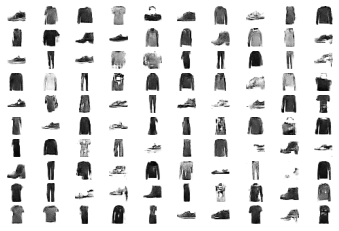

EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
>71, 1/468, d1=0.677, d2=0.667 g=0.782
>71, 2/468, d1=0.648, d2=0.663 g=0.775
>71, 3/468, d1=0.678, d2=0.686 g=0.768
>71, 4/468, d1=0.701, d2=0.669 g=0.795
>71, 5/468, d1=0.655, d2=0.656 g=0.764
>71, 6/468, d1=0.641, d2=0.653 g=0.754
>71, 7/468, d1=0.632, d2=0.627 g=0.739
>71, 8/468, d1=0.655, d2=0.656 g=0.765
>71, 9/468, d1=0.685, d2=0.639 g=0.782
>71, 10/468, d1=0.657, d2=0.628 g=0.731
>71, 11/468, d1=0.641, d2=0.638 g=0.785
>71, 12/468, d1=0.643, d2=0.677 g=0.759
>71, 13/468, d1=0.654, d2=0.687 g=0.818
>71, 14/468, d1=0.642, d2=0.647 g=0.798
>71, 15/468, d1=0.653, d2=0.660 g=0.793
>71, 16/468, d1=0.691, d2=0.690 g=0.778
>71, 17/468, d1=0.695, d2=0.670 g=0.741
>71, 18/468, d1=0.674, d2=0.634 g=0.755
>71, 19/468, d1=0.651, d2=0.651 g=0.755
>71, 20/468, d1=0.634, d2=0.657 g=0.798
>71, 21/468, d1=0.638, d2=0.678 g=0.770
>71, 22/468, d1=0.632, d2=0.686 g=0.829
>71, 23/468, d1=0.656, d2=0.683 g=0.783
>71, 24/468, d1=0.652, d2=0.670 g=0.801
>71,

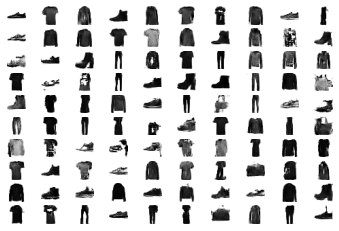

EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
>76, 1/468, d1=0.666, d2=0.630 g=0.809
>76, 2/468, d1=0.680, d2=0.652 g=0.805
>76, 3/468, d1=0.698, d2=0.669 g=0.799
>76, 4/468, d1=0.655, d2=0.661 g=0.765
>76, 5/468, d1=0.698, d2=0.668 g=0.778
>76, 6/468, d1=0.648, d2=0.657 g=0.793
>76, 7/468, d1=0.636, d2=0.671 g=0.789
>76, 8/468, d1=0.677, d2=0.612 g=0.803
>76, 9/468, d1=0.692, d2=0.660 g=0.771
>76, 10/468, d1=0.672, d2=0.674 g=0.757
>76, 11/468, d1=0.646, d2=0.686 g=0.740
>76, 12/468, d1=0.663, d2=0.698 g=0.745
>76, 13/468, d1=0.685, d2=0.668 g=0.796
>76, 14/468, d1=0.689, d2=0.628 g=0.811
>76, 15/468, d1=0.663, d2=0.653 g=0.822
>76, 16/468, d1=0.666, d2=0.683 g=0.788
>76, 17/468, d1=0.641, d2=0.668 g=0.784
>76, 18/468, d1=0.650, d2=0.675 g=0.753
>76, 19/468, d1=0.703, d2=0.686 g=0.784
>76, 20/468, d1=0.662, d2=0.651 g=0.788
>76, 21/468, d1=0.668, d2=0.669 g=0.814
>76, 22/468, d1=0.683, d2=0.623 g=0.807
>76, 23/468, d1=0.666, d2=0.677 g=0.787
>76, 24/468, d1=0.648, d2=0.670 g=0.791
>76,

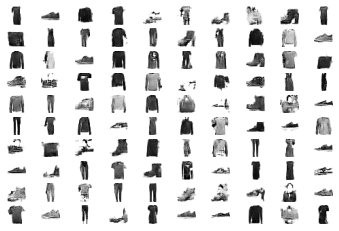

EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
>81, 1/468, d1=0.724, d2=0.639 g=0.777
>81, 2/468, d1=0.663, d2=0.646 g=0.781
>81, 3/468, d1=0.711, d2=0.678 g=0.761
>81, 4/468, d1=0.661, d2=0.682 g=0.762
>81, 5/468, d1=0.709, d2=0.651 g=0.805
>81, 6/468, d1=0.649, d2=0.675 g=0.789
>81, 7/468, d1=0.608, d2=0.668 g=0.770
>81, 8/468, d1=0.655, d2=0.668 g=0.786
>81, 9/468, d1=0.687, d2=0.635 g=0.755
>81, 10/468, d1=0.687, d2=0.660 g=0.798
>81, 11/468, d1=0.710, d2=0.677 g=0.760
>81, 12/468, d1=0.674, d2=0.670 g=0.783
>81, 13/468, d1=0.671, d2=0.623 g=0.800
>81, 14/468, d1=0.647, d2=0.677 g=0.800
>81, 15/468, d1=0.729, d2=0.657 g=0.815
>81, 16/468, d1=0.683, d2=0.631 g=0.763
>81, 17/468, d1=0.633, d2=0.671 g=0.778
>81, 18/468, d1=0.639, d2=0.674 g=0.760
>81, 19/468, d1=0.699, d2=0.623 g=0.762
>81, 20/468, d1=0.656, d2=0.651 g=0.759
>81, 21/468, d1=0.668, d2=0.659 g=0.764
>81, 22/468, d1=0.627, d2=0.667 g=0.775
>81, 23/468, d1=0.650, d2=0.663 g=0.805
>81, 24/468, d1=0.636, d2=0.689 g=0.760
>81,

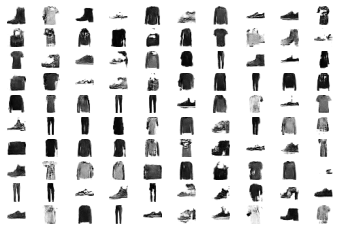

EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
>86, 1/468, d1=0.676, d2=0.656 g=0.770
>86, 2/468, d1=0.619, d2=0.686 g=0.753
>86, 3/468, d1=0.609, d2=0.626 g=0.766
>86, 4/468, d1=0.680, d2=0.633 g=0.783
>86, 5/468, d1=0.641, d2=0.635 g=0.789
>86, 6/468, d1=0.642, d2=0.693 g=0.813
>86, 7/468, d1=0.700, d2=0.657 g=0.773
>86, 8/468, d1=0.712, d2=0.681 g=0.782
>86, 9/468, d1=0.636, d2=0.681 g=0.769
>86, 10/468, d1=0.708, d2=0.663 g=0.799
>86, 11/468, d1=0.626, d2=0.656 g=0.782
>86, 12/468, d1=0.690, d2=0.641 g=0.755
>86, 13/468, d1=0.670, d2=0.652 g=0.802
>86, 14/468, d1=0.695, d2=0.619 g=0.822
>86, 15/468, d1=0.676, d2=0.674 g=0.764
>86, 16/468, d1=0.638, d2=0.670 g=0.790
>86, 17/468, d1=0.694, d2=0.649 g=0.766
>86, 18/468, d1=0.683, d2=0.666 g=0.786
>86, 19/468, d1=0.697, d2=0.677 g=0.780
>86, 20/468, d1=0.687, d2=0.692 g=0.782
>86, 21/468, d1=0.673, d2=0.682 g=0.764
>86, 22/468, d1=0.650, d2=0.659 g=0.760
>86, 23/468, d1=0.649, d2=0.683 g=0.779
>86, 24/468, d1=0.629, d2=0.654 g=0.763
>86,

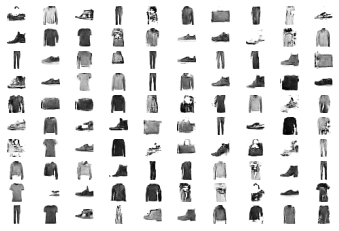

EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
>91, 1/468, d1=0.662, d2=0.635 g=0.810
>91, 2/468, d1=0.678, d2=0.642 g=0.789
>91, 3/468, d1=0.699, d2=0.665 g=0.788
>91, 4/468, d1=0.660, d2=0.656 g=0.790
>91, 5/468, d1=0.693, d2=0.646 g=0.793
>91, 6/468, d1=0.654, d2=0.654 g=0.791
>91, 7/468, d1=0.701, d2=0.644 g=0.744
>91, 8/468, d1=0.633, d2=0.671 g=0.754
>91, 9/468, d1=0.688, d2=0.695 g=0.781
>91, 10/468, d1=0.716, d2=0.611 g=0.755
>91, 11/468, d1=0.684, d2=0.694 g=0.800
>91, 12/468, d1=0.656, d2=0.674 g=0.785
>91, 13/468, d1=0.657, d2=0.652 g=0.768
>91, 14/468, d1=0.637, d2=0.714 g=0.786
>91, 15/468, d1=0.699, d2=0.639 g=0.770
>91, 16/468, d1=0.681, d2=0.668 g=0.798
>91, 17/468, d1=0.703, d2=0.645 g=0.775
>91, 18/468, d1=0.706, d2=0.640 g=0.780
>91, 19/468, d1=0.653, d2=0.646 g=0.787
>91, 20/468, d1=0.664, d2=0.686 g=0.795
>91, 21/468, d1=0.669, d2=0.667 g=0.775
>91, 22/468, d1=0.705, d2=0.661 g=0.775
>91, 23/468, d1=0.661, d2=0.638 g=0.799
>91, 24/468, d1=0.641, d2=0.645 g=0.827
>91,

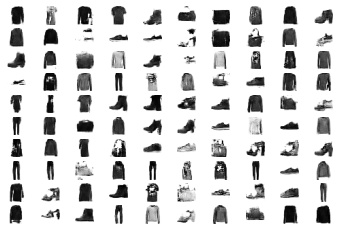

EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
>96, 1/468, d1=0.687, d2=0.651 g=0.833
>96, 2/468, d1=0.659, d2=0.641 g=0.776
>96, 3/468, d1=0.593, d2=0.732 g=0.795
>96, 4/468, d1=0.725, d2=0.669 g=0.763
>96, 5/468, d1=0.651, d2=0.689 g=0.780
>96, 6/468, d1=0.652, d2=0.665 g=0.776
>96, 7/468, d1=0.640, d2=0.696 g=0.774
>96, 8/468, d1=0.677, d2=0.717 g=0.800
>96, 9/468, d1=0.651, d2=0.705 g=0.779
>96, 10/468, d1=0.636, d2=0.641 g=0.823
>96, 11/468, d1=0.643, d2=0.652 g=0.826
>96, 12/468, d1=0.675, d2=0.647 g=0.846
>96, 13/468, d1=0.685, d2=0.641 g=0.822
>96, 14/468, d1=0.614, d2=0.644 g=0.787
>96, 15/468, d1=0.720, d2=0.643 g=0.765
>96, 16/468, d1=0.696, d2=0.654 g=0.792
>96, 17/468, d1=0.688, d2=0.634 g=0.844
>96, 18/468, d1=0.700, d2=0.684 g=0.785
>96, 19/468, d1=0.735, d2=0.688 g=0.771
>96, 20/468, d1=0.678, d2=0.678 g=0.753
>96, 21/468, d1=0.725, d2=0.630 g=0.789
>96, 22/468, d1=0.640, d2=0.660 g=0.810
>96, 23/468, d1=0.649, d2=0.651 g=0.810
>96, 24/468, d1=0.730, d2=0.673 g=0.763
>96,

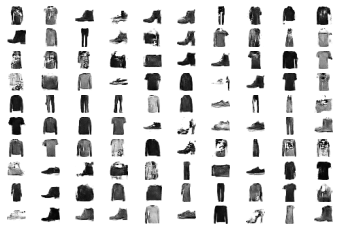

EPOCH 97
EPOCH 98
EPOCH 99
EPOCH 100


In [ ]:
# train the generator and discriminator
n_epochs=100
n_batch=128

bat_per_epo = int(dataset[0].shape[0] / n_batch)
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # enumerate batches over the training set
    print("EPOCH", i+1)
    for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
        # generate 'fake' examples
        [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
        # prepare points in latent space as input for the generator
        [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        if i%5 == 0:
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
              (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if i%5 == 0:
        plotGeneratedImages(generator, latent_dim)

In [ ]:
# save the models

generator.save("fashion_cgan_generator.h5")
generator.save_weights("fashion_cgan_generator_weights.h5")
discriminator.save("fashion_cgan_discriminator.h5")
discriminator.save_weights("fashion_cgan_discriminator_weights.h5")
gan.save("fashion_cgan_gan.h5")
gan.save_weights("fashion_cgan_gan_weights.h5")

In [ ]:
!ls -la

total 6092
drwxr-xr-x 1 root root    4096 Jan 29 12:40 .
drwxr-xr-x 1 root root    4096 Jan 29 11:55 ..
drwxr-xr-x 4 root root    4096 Jan  7 14:33 .config
-rw-r--r-- 1 root root  671360 Jan 29 12:40 fashion_cgan_discriminator.h5
-rw-r--r-- 1 root root  235992 Jan 29 12:40 fashion_cgan_discriminator_weights.h5
-rw-r--r-- 1 root root 2631376 Jan 29 12:40 fashion_cgan_gan.h5
-rw-r--r-- 1 root root 1032656 Jan 29 12:40 fashion_cgan_gan_weights.h5
-rw-r--r-- 1 root root  821560 Jan 29 12:40 fashion_cgan_generator.h5
-rw-r--r-- 1 root root  816152 Jan 29 12:40 fashion_cgan_generator_weights.h5
drwxr-xr-x 1 root root    4096 Jan  7 14:33 sample_data


### **Generación de imágenes nuevas**

In [ ]:
# load model
model = load_model('fashion_cgan_generator.h5')

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


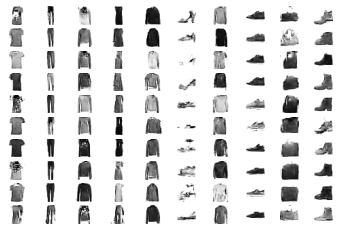

In [ ]:
plotGeneratedImages(model, latent_dim, order_class=True)

In [ ]:
if COLAB:
    from google.colab import files
    files.download('fashion_cgan_generator.h5')
    files.download('fashion_cgan_generator_weights.h5')
    files.download('fashion_cgan_discriminator.h5')
    files.download('fashion_cgan_discriminator_weights.h5')
    files.download('fashion_cgan_gan.h5')
    files.download('fashion_cgan_gan_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ejercicio:

- Adaptar el ejercicio a la base de datos CIFAR-10

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data as load_data_cifar10

In [ ]:
?load_data_cifar10